In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
import sys
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
from scipy.stats import expon, norm, uniform

In [2]:
#ロボットの世界を表すクラスで、ロボットやランドマークなどのオブジェクトを管理し、描画やシミュレーションを行うメソッド
class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []  
        self.debug = debug
        self.time_span = time_span  
        self.time_interval = time_interval 
        
    def append(self,obj):  
        self.objects.append(obj)
    
    def draw(self): 
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')             
        ax.set_xlim(-10,10)                  
        ax.set_ylim(-10,10) 
        ax.set_xlabel("X",fontsize=10)                 
        ax.set_ylabel("Y",fontsize=10)                 
        
        elems = []
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-9.4, 9.0, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)    


In [3]:
#理想的なロボットを表すクラスで、ロボットの姿勢、色、センサ、描画などの情報を持ち、動作や描画
class IdealRobot:   
    def __init__(self, pose, agent=None, sensor=None, color="black"):    # 引数を追加
        self.pose = pose
        self.r = 0.2  
        self.color = color 
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor    # 追加
    
    def draw(self, ax, elems):         ### call_agent_draw
        x, y, theta = self.pose 
        xn = x + self.r * math.cos(theta)  
        yn = y + self.r * math.sin(theta)  
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        s = "({:.2f}, {:.2f}, {})".format(x,y,int(theta*180/math.pi)%360)
        elems.append(ax.text(x, y+2.1, s, fontsize=8))
        if self.sensor and len(self.poses) > 1: 
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent, "draw"):                               #以下2行追加   
            self.agent.draw(ax, elems)
    
         
    @classmethod           
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
             return pose + np.array( [nu*math.cos(t0), 
                                      nu*math.sin(t0),
                                      omega ] ) * time
        else:
             return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                      nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                      omega*time ] )
    

#     def one_step(self, time_interval):
#         if not self.agent: return        
#         obs =self.sensor.data(self.pose) if self.sensor else None #追加
#         nu, omega = self.agent.decision(obs) #引数追加
#         self.pose = self.state_transition(nu, omega, time_interval, self.pose)
#         if self.sensor: self.sensor.data(self.pose)   


In [4]:
#IdealRobot を継承し、ロボットのノイズやバイアス現実的な挙動をシミュレーション
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color="black",
                 noise_per_meter=5, noise_std=math.pi/60,
                 bias_rate_stds=(0.1,0.1)):
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1])

    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
        return pose

    def bias(self, nu, omega):
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def one_step(self, time_interval):
        if not self.agent:
            return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.ver()
        nu, omega = self.bias(nu, omega)
        
        
        # スタックと誘拐の部分を削除
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.agent.decision(obs, self.pose)
        

In [5]:
#ロボットの行動を決定するエージェントを表すクラスで、速度や角速度を持ち、ロボットの動作を制御
class Agent: 
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self, observation=None):
        return self.nu, self.omega


In [6]:
#ランドマークを表すクラスで、位置情報とIDを持ち、描画されることで表示
class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=50, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=5))


In [7]:
#ンドマークの集合を管理するクラスで、ランドマークを追加して描画
class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.landmarks = []
        
    def append_landmark(self, landmark):       # ランドマークを追加
        landmark.id = len(self.landmarks)           # 追加するランドマークにIDを与える
        self.landmarks.append(landmark)

    def draw(self, ax, elems):                 # 描画（Landmarkのdrawを順に呼び出し）
        for lm in self.landmarks: lm.draw(ax, elems)


In [8]:
#理想的なカメラを表すクラスで、ランドマークの観測をシミュレーション
class IdealCamera:
    def __init__(self, env_map,                  distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range = direction_range
        
    def visible(self, polarpos):  # ランドマークが計測できる条件
        if polarpos is None:
            return False
        
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1]     and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):               # 条件を追加
                observed.append((z, lm.id))   # インデント
            
        self.lastdata = observed 
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        return np.array( [np.hypot(*diff), phi ] ).T
    
    def draw(self, ax, elems, cam_pose): 
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx], [y,ly], color="pink")


In [9]:
#IdealCamera を継承し、観測にノイズやバイアス、ファントム観測などを追加
class Camera(IdealCamera):
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90,
                 oversight_prob=0.1):  # 遮蔽の削除に伴い、関連する変数も削除
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise  
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev) 
        
        self.oversight_prob = oversight_prob
        
    def noise(self, relpos):  
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos): 
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std,
                                  self.direction_bias]).T
    
    def oversight(self, relpos):
        if uniform.rvs() < self.oversight_prob:
            return None
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            z = self.oversight(z)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)  
                observed.append((z, lm.id))
            
        self.lastdata = observed 
        return observed



In [10]:
#推定を行うエージェントで、カルマンフィルタを使用して姿勢推定
class EstimationAgent(Agent): 
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def ver(self):
        return self.nu, self.omega
    
        
    def decision(self, observation=None, pose = None): 
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval, pose)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        
        
    def draw(self, ax, elems): ###mlwrite
        self.estimator.draw(ax, elems)
        x, y, t = self.estimator.pose #以下追加
        s = "({:.2f}, {:.2f}, {})".format(x,y,int(t*180/math.pi)%360)
        elems.append(ax.text(x, y+0.1, s, fontsize=8))


In [14]:
def sigma_ellipse(p, cov, n):
    eig_vals, eig_vec = np.linalg.eig(cov)
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
    return Ellipse(p, width=2*n*math.sqrt(eig_vals[0]),height=2*n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

def matM(rotf, trans, rots, stds):
    return np.diag([stds["nn"]*rotf**2 + stds["no"]*trans**2, 
                    stds["on"]*trans**2 + stds["oo"]*(rotf**2 + rots**2),
                    stds["nn"]*rotf**2 + stds["no"]*trans**2])

# def matM(rotf, trans, rots, stds):
#     return np.diag([stds["nn"]*rotf, 
#                     stds["on"]*trans,
#                     stds["nn"]*rotf])
    
def matA(rotf, trans, rots, theta):
    tr = theta + rotf
    return np.array([[-trans*math.sin(tr), math.cos(tr), 0],
                                 [trans*math.cos(tr), math.sin(tr), 0],
                                 [1,    0   ,   1]] )

def matG(rotf, trans, rots, theta):
    G = np.diag([1.0, 1.0, 1.0])
    G[0, 2] = -trans * math.sin(theta+rotf)
    G[1, 2] = trans * math.cos(theta+rotf)
    return G

def matH(pose, landmark_pos): ###kf4funcs
    mx, my = landmark_pos
    mux, muy, mut = pose
    q = (mux - mx)**2 + (muy - my)**2
    return np.array([[(mux - mx)/np.sqrt(q), (muy - my)/np.sqrt(q), 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]])

def matQ(distance_dev, direction_dev):
    return np.diag(np.array([distance_dev**2, direction_dev**2]))

def meanUpdate(current_mean,rotf,trans,rots):
    return current_mean + np.array([trans*math.cos(current_mean[2]+rotf),trans*math.sin(current_mean[2]+rotf),rotf+rots])

In [15]:
#カルマンフィルタを実装したクラスで、姿勢の推定を行います。観測更新と運動更新のメソッド
class KalmanFilter: ###kf4init
    def __init__(self, envmap, initial_pose, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05): #変数追加
        self.belief = multivariate_normal(mean=initial_pose, cov=np.diag([0.02, 0.02, 0.02])) 
        self.pose = self.belief.mean
        self.motion_noise_stds = motion_noise_stds
        self.map = envmap  #以下3行追加（Mclと同じ）
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        self.odo = self.belief.mean
        
    def observation_update(self, observation):  #追加
        for d in observation:
            z = d[0]
            obs_id = d[1]
            
            H = matH(self.belief.mean, self.map.landmarks[obs_id].pos)
            estimated_z = IdealCamera.observation_function(self.belief.mean, self.map.landmarks[obs_id].pos)
            Q = matQ(estimated_z[0]*self.distance_dev_rate, self.direction_dev)
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T)))
            
            _mean = self.belief.mean + K.dot(z - estimated_z)
            _cov  = (np.eye(3) - K.dot(H)).dot(self.belief.cov)
            self.belief = multivariate_normal(mean = _mean, cov = _cov)


            self.pose = self.belief.mean

    def motion_update(self, nu, omega, time, current_odo):
        if abs(omega) < 1e-5: omega = 1e-5 #値が0になるとゼロ割りになって計算ができないのでわずかに値を持たせる
            
        dx = current_odo[0]-self.odo[0]
        dy = current_odo[1]-self.odo[1]
        if abs(dx) < 1e-5:dx = 1e-5
        
        rotf = math.atan2(dy, dx)
        trans = np.sqrt(dx**2 + dy**2)
        rots = current_odo[2] - self.odo[2] - rotf
        

        M = matM(rotf, trans, rots, self.motion_noise_stds)
        V = matA(rotf, trans, rots, self.belief.mean[2])
        G = matG(rotf, trans, rots, self.belief.mean[2])
    

        _cov  = G.dot(self.belief.cov).dot(G.T) + V.dot(M).dot(V.T)
        _mean = meanUpdate(self.belief.mean, rotf, trans, rots)
#         self.odo =
        #_mean = nu * time
        self.belief = multivariate_normal(mean = _mean, cov = _cov)

        self.pose = self.belief.mean #他のクラスで使う
        self.odo = current_odo

    def draw(self, ax, elems):
        ###xy平面上の誤差の3シグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)
        a,b,d = self.odo
        e = "({:.2f}, {:.2f}, {})".format(a,b,int(d*180/math.pi)%360)         
        elems.append(ax.text(a, b+5.1, e, fontsize=8))


<IPython.core.display.Javascript object>


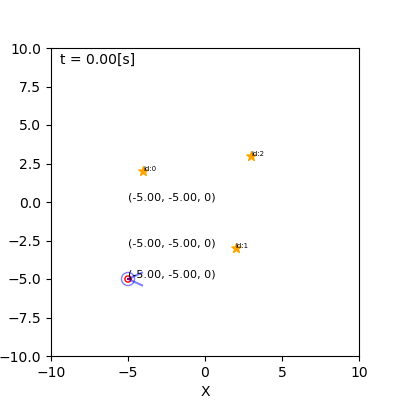

<IPython.core.display.Javascript object>


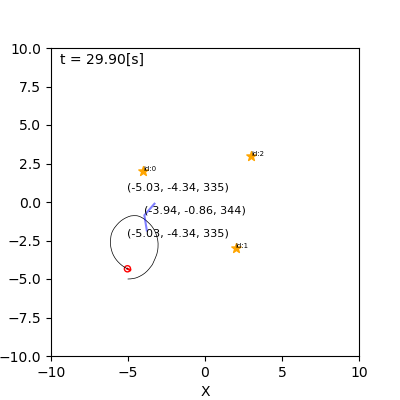

<IPython.core.display.Javascript object>


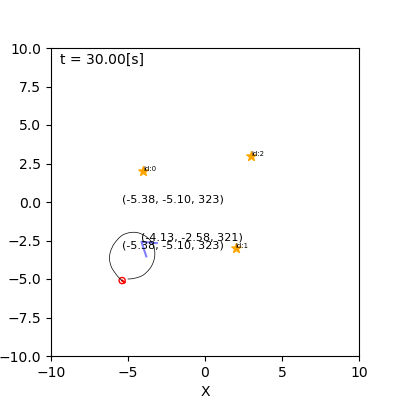

In [17]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    initial_pose = np.array([-5, -5, 0]).T
    kf = KalmanFilter(m, initial_pose)
    circling = EstimationAgent(time_interval, 0.3, 10.0/180*math.pi, kf)
    r = Robot(initial_pose, sensor=Camera(m), agent=circling, color="red")
    world.append(r)
    
#     kf = KalmanFilter(m, initial_pose)
#     linear = EstimationAgent(time_interval, 0.1, 0.0, kf)
#     r = Robot(initial_pose, sensor=Camera(m), agent=linear, color="red")
#     world.append(r)
    
#     kf = KalmanFilter(m, initial_pose)
#     right = EstimationAgent(time_interval, 0.1, -3.0/180*math.pi, kf)
#     r = Robot(initial_pose, sensor=Camera(m), agent=right, color="red")
#     world.append(r)

    world.draw()